In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [2]:
incident = pd.read_csv('data.csv')
incident.head()

,months_as_customer,age,policy_number,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,...,bodily_injuries,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,OH,250/500,1000,1406.91,0,MALE,MD,...,1,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,IN,250/500,2000,1197.22,5000000,MALE,MD,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,...,2,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,...,1,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,IL,500/1000,1000,1583.91,6000000,MALE,Associate,...,0,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [3]:
# Bước 2: Tiền xử lý dữ liệu
# Thay thế '?' bằng NaN và loại bỏ các hàng chứa giá trị NaN
incident = incident.replace('?', pd.NA).dropna()

In [4]:
# Xóa các thuộc tính không cần thiết
unnecessary_columns = ['policy_number', 'incident_date', 'auto_make', 'auto_model', 'auto_year','insured_sex','incident_type','number_of_vehicles_involved','police_report_available','umbrella_limit','bodily_injuries','policy_deductable','policy_csl','collision_type','policy_state','insured_education_level','insured_relationship','property_damage']
incident = incident.drop(columns=unnecessary_columns)

In [5]:
# Chuyển các cột phân loại sang kiểu string để mã hóa nhất quán
for column in incident.select_dtypes(include=['object']).columns:
    incident[column] = incident[column].astype(str)

In [6]:
# Bước 3: Mã hóa các thuộc tính phân loại
label_encoders = {}
for column in incident.select_dtypes(include=['object']).columns:
    if column != 'fraud_reported':  # Loại trừ cột mục tiêu
        le = LabelEncoder()
        incident[column] = le.fit_transform(incident[column])
        label_encoders[column] = le

# Mã hóa cột mục tiêu 'fraud_reported'
target_encoder = LabelEncoder()
incident['fraud_reported'] = target_encoder.fit_transform(incident['fraud_reported'])

In [7]:
# Bước 4: Chia dữ liệu thành biến đặc trưng và biến mục tiêu
feature = incident.drop('fraud_reported', axis=1)
label = incident['fraud_reported']

In [8]:
# Bước 5: Chia dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=0.1, random_state=0) # Changed lable_train, lable_test to label_train, label_test
feature_train, feature_val, label_train, label_val = train_test_split(feature_train, label_train, test_size=0.1, random_state=0) # Changed lable_train, lable_val to label_train, label_val

In [9]:
# Áp dụng SMOTE cho tập huấn luyện để cân bằng dữ liệu
smote = SMOTE(random_state=42)
feature_train_smote, label_train_smote = smote.fit_resample(feature_train, label_train)

In [10]:
# Thiết lập và huấn luyện mô hình Decision Tree với GridSearchCV để tối ưu các tham số
param_grid = {
    'max_depth': [4, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'ccp_alpha': [0, 0.005, 0.01]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(feature_train_smote, label_train_smote)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0, 0.005, 0.01], 'max_depth': [4, 5, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [11]:
# Lấy mô hình với các tham số tốt nhất
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'ccp_alpha': 0.01, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [12]:
# Đánh giá mô hình trên tập huấn luyện và tập xác thực
train_accuracy = accuracy_score(label_train_smote, best_model.predict(feature_train_smote))
val_accuracy = accuracy_score(label_val, best_model.predict(feature_val))
print(f"Độ chính xác trên tập huấn luyện: {train_accuracy:.4f}")
print(f"Độ chính xác trên tập xác thực: {val_accuracy:.4f}")

Độ chính xác trên tập huấn luyện: 0.9053
Độ chính xác trên tập xác thực: 0.8710


In [13]:
# Đánh giá chi tiết với Cross-Validation
cv_scores = cross_val_score(best_model, feature_train_smote, label_train_smote, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Độ chính xác trung bình với Cross-Validation:", np.mean(cv_scores))

Cross-Validation Scores: [0.85542169 0.89156627 0.84146341 0.81707317 0.87804878]
Độ chính xác trung bình với Cross-Validation: 0.8567146635321775


# show char

     Training Size  Training Error (RMSE)  Validation Error (RMSE)
0                1               0.000000                 0.485071
1                2               0.000000                 0.485071
2                3               0.000000                 0.485071
3                4               0.000000                 0.485071
4                5               0.000000                 0.618347
..             ...                    ...                      ...
269            270               0.285450                 0.342997
270            271               0.291326                 0.342997
271            272               0.290790                 0.342997
272            273               0.296500                 0.342997
273            274               0.295958                 0.342997

[274 rows x 3 columns]


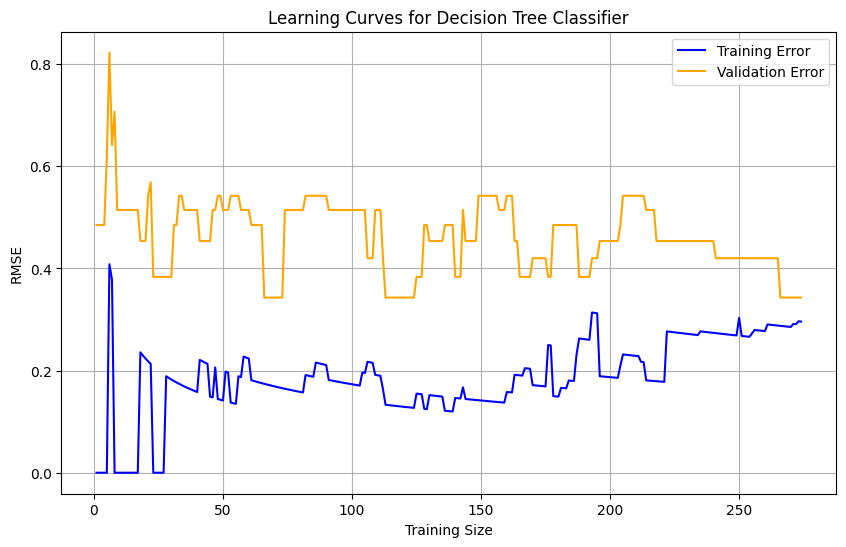

In [15]:
# Danh sách để lưu trữ lỗi
train_errors = []
test_errors = []

# Huấn luyện mô hình trên các kích thước tập huấn luyện khác nhau
for m in range(1, len(feature_train)):
    best_model.fit(feature_train[:m], label_train[:m])  # Huấn luyện trên m mẫu
    lable_train_predict = best_model.predict(feature_train[:m])
    lable_test_predict = best_model.predict(feature_test)

    # Tính toán lỗi RMSE
    train_errors.append(np.sqrt(mean_squared_error(label_train[:m], lable_train_predict)))
    test_errors.append(np.sqrt(mean_squared_error(label_test, lable_test_predict)))

# Tạo DataFrame để hiển thị sai số
error_df = pd.DataFrame({
    'Training Size': range(1, len(feature_train)),
    'Training Error (RMSE)': train_errors,
    'Validation Error (RMSE)': test_errors
})

print(error_df)

# Vẽ đường cong học
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(feature_train)), train_errors, label='Training Error', color='blue')
plt.plot(range(1, len(feature_train)), test_errors, label='Validation Error', color='orange')
plt.title('Learning Curves for Decision Tree Classifier')
plt.xlabel('Training Size')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [17]:
test_accuracy = accuracy_score(label_test, best_model.predict(feature_test))
print(f"Độ chính xác trên tập kiểm tra: {test_accuracy:.4f}")

Độ chính xác trên tập kiểm tra: 0.8824
